In [1]:
from  __future__  import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time, ast

import numpy as np

import cv2, imutils
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Model
<img src="misc/misc1.png">
<img src="misc/misc2.png">
<p hidden>
### Classification
| Layer | kernel | stride | output | shape |
|-------|-------|-------|-------|-------|
|Input       |    |   |            |(1080, 1920, 3)|
|Convolution|    3×3 |     1      |(1080, 1920, 16)|
|MaxPooling |    3×4  |    2      |(360, 480, 16)|
|Convolution |   3×3   |   1      |(360, 480, 32)|
|MaxPooling   |  3×4    |  2      |(120, 120, 32)|
|Convolution   | 3×3     | 1      |(120, 120, 64)|
|MaxPooling |    2×2      |2      |(60, 60, 64)|
|Convolution |   3×3      |1      |(60, 60, 128)|
|MaxPooling   |  2×2|      2      |(30, 30, 128)|
|Convolution   | 3×3 |     1      |(30, 30, 256)|
|MaxPooling  |   2×2  |    2      |(15, 15, 256)|
|Convolution  |  3×3   |   1      |(15, 15, 512)|
|MaxPooling    | 2×2    |  1      |(15, 15, 512)|
|Convolution|    3×3     | 1      |(15, 15, 1024)|
|Convolution |   3×3      |1      |(15, 15, 1024)|
|Convolution  |  1×1      |1      |(15, 15, 125)|</p>

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


### Loading the data

In [5]:
get_bounding_box_params = lambda text: ast.literal_eval("("+text.split("(")[1].split(")")[0]+")")

In [6]:
def generate_batch(batch_size=128, vids_path="Data/Videos", annots_path="Data/Video_Annotation", w=100, h=100):
    frames = []
    labels = []
    bb_params = []
    vids = os.listdir(vids_path)
    explored_vids = {}  # vid_path: number of un-explored frames, or True flag that it has been explored
    while sum([v is True for v in explored_vids.values()]) < len(vids):
        v = np.random.choice(vids)  # pick a video
        vid_path = os.path.join(vids_path, v)
        vs = cv2.VideoCapture(vid_path)  # open the video

        explored_vids.setdefault(v, 0)
        if explored_vids[v] is True:  # check whether all its frames have been explored
            continue
        annot_filename = os.path.splitext(os.path.basename(vid_path))[0] + "_gt.txt"  # get the video annotations
        annot_path = os.path.join(annots_path, annot_filename)

        frame_no = explored_vids[v]  # explore the current frame
        vs.set(1, frame_no)
        frame = vs.read()[1]
        if frame is None:  # no more frames
            explored_vids[v] = True
            continue
        else:
            explored_vids[v] = frame_no + 1  # increment the frame index in that video
            H, W = frame.shape[:2]
            x_scale = float(W) / w
            y_scale = float(H) / h
            #                     frame = imutils.resize(frame, width=int(W*scale), height=int(H*scale))
            frame = cv2.resize(frame, (w, h))
            label = True
            with open(annot_path, 'r') as annotations:
                for line_i, line in enumerate(annotations):
                    if line_i == frame_no:
                        try:
                            bounding_box_params = get_bounding_box_params(line)
                        except IndexError:
                            label = False
                            bounding_box_params = (0, 0, 0, 0)
                        break

                x_, y_, w_, h_ = bounding_box_params

                bounding_box_params = np.array(
                    [int(x_ / x_scale), int(y_ / y_scale), int(w_ / x_scale), int(h_ / y_scale)])
                frames.append(frame)
                bb_params.append(bounding_box_params)
                labels.append(int(label))
                if len(labels) == batch_size:
                    yield np.array(frames), np.array(bb_params), np.array(labels).reshape(-1, 1)
                    frames = []
                    labels = []
                    bb_params = []

In [7]:
def get_annotations(file, annotations_path):
    annotation_path = os.path.join(annotations_path, file.split(".")[0]+".txt")
    with open(annotation_path, "r") as f:
        return ast.literal_eval(f.read())

def generate_image_batches(positives_path="Data/positives",
                           negatives_path="Data/negatives",
                           annotations_path="Data/annotations",
                           batch_ratio=0.2, w=100, h=100):
    positives = os.listdir(positives_path)
    negatives = os.listdir(negatives_path)
    batch_size = int(len(positives)*batch_ratio)
    read_image = lambda path: cv2.imread(path)
    for k in range(1, len(positives)+1, batch_size//2):
        positive_files = positives[k: k+batch_size//2]
        negative_files = negatives[k: k+batch_size//2]
            
        labels = [[1, 0]]*len(positive_files) + [[0, 1]]*len(negative_files)
#         labels = [1]*len(positive_files) + [0]*len(negative_files)
        
        positive_imgs = [read_image(os.path.join(positives_path, img)) for img in positive_files]
        negative_imgs = [read_image(os.path.join(negatives_path, img)) for img in negative_files]
        imgs = positive_imgs + negative_imgs
        H, W = imgs[0].shape[:2]
        if W != w or H != h:
            x_scale = W/float(w)
            y_scale = H/float(h)
            
            imgs = np.array([cv2.resize(img, (w,h)) for img in imgs])
            
        else:
            x_scale = 1
            y_scale = 1
        annotations = [get_annotations(img, annotations_path)
                       for img in positive_files] + [(0,0,0,0)]*len(negative_files)
        
        batch_imgs = np.array(imgs[:batch_size])
        batch_labels = np.array(labels[:batch_size])
        batch_annotations = np.array(annotations[:batch_size])
        
        idxs = np.random.permutation(range(len(batch_imgs)))
        
        yield batch_imgs[idxs], batch_annotations[idxs], batch_labels[idxs]

In [8]:
in_channels  = 3
height = 100
width = 100
out_channels1 = 16
out_channels2 = 64
out_channels3 = 128
out_channels4 = 256

graph = tf.Graph()
with graph.as_default():
    he_init = tf.variance_scaling_initializer()
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=[None, height, width, in_channels], name="X")
        y = tf.placeholder(tf.float32, shape=[None, 2], name="y")
        bb_params = tf.placeholder(tf.float32, shape=[None, 4], name="bb_params")
        keep_prob = tf.placeholder_with_default(0.5, shape=[], name='keep_prob')
        
    with tf.name_scope("filters"):
        filter1 =  tf.Variable(tf.truncated_normal([3, 3, in_channels, out_channels1]))
        filter2 = tf.Variable(tf.truncated_normal([3, 3, out_channels1, out_channels2]))
        filter3 = tf.Variable(tf.truncated_normal([3, 3, out_channels2, out_channels3]))
        filter4 = tf.Variable(tf.truncated_normal([3, 3, out_channels3, out_channels4]))

    with tf.name_scope("Layers"):

        conv1 = tf.nn.conv2d(X, filter1, [1,2,2,1], "SAME", name="CONV1", )
        conv1 = tf.nn.dropout(tf.nn.relu(conv1), keep_prob=keep_prob)

        pool1 = tf.nn.pool(conv1, [3,3], "MAX", "SAME", name="pool1")

        conv2 = tf.nn.conv2d(pool1, filter2, [1,2,2,1], "SAME", name="CONV2")
        conv2 = tf.nn.dropout(tf.nn.relu(conv2), keep_prob=keep_prob)

        pool2 = tf.nn.pool(conv2, [3,3], "MAX", "SAME", name="pool2")

        conv3 = tf.nn.conv2d(pool2, filter3, [1,2,2,1], "SAME", name="CONV3")
        conv3 = tf.nn.dropout(tf.nn.relu(conv3), keep_prob=keep_prob)

        pool3 = tf.nn.pool(conv3, [3,3], "MAX", "SAME", name="pool3")

        conv4 = tf.nn.conv2d(pool3, filter4, [1,2,2,1], "SAME", name="CONV4")
        conv4 = tf.nn.dropout(tf.nn.relu(conv4), keep_prob=keep_prob)

        pool4 = tf.nn.pool(conv4, [3,3], "MAX", "SAME", name="pool4")

        output_layer = tf.layers.Flatten()(pool4)

    with tf.name_scope("FC_layers"):
        
        fc1 = tf.layers.dense(output_layer, 64, name="fc1", activation=tf.nn.relu, kernel_initializer=he_init)
        fc2 = tf.layers.dense(output_layer, 64, name="fc2", activation=tf.nn.relu, kernel_initializer=he_init)
    
    with tf.name_scope("Logits"):
        bb_logits = tf.layers.dense(fc1, 4, name="bb_logits", activation=tf.nn.relu)
        y_logits = tf.layers.dense(fc2, 2, name="y_logits")  # default activation None    
    
    with tf.name_scope("train"):
        mse = tf.losses.mean_squared_error(predictions=bb_logits, labels=bb_params)
        xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_logits)
        loss = tf.reduce_mean(xentropy) + tf.reduce_mean(mse)
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        predictions = tf.cast(tf.greater(y_logits, 0.5), tf.float32)
        correct = tf.equal(predictions, y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

### Training

In [10]:
epochs = 100
display_step = 13

In [11]:
losses = []
mses = []
accs = []
with tf.Session(graph=graph) as sess:
    counter = 0
    for epoch_i in range(epochs):
        for i, (x_batch, bb_params_batch, y_batch) in enumerate(
            generate_image_batches(w=width, h=height)):
            sess.run(init)
            _, mse_val,loss_val= sess.run([training_op, mse, loss], feed_dict={
                X:x_batch, bb_params:bb_params_batch, y:y_batch, keep_prob:0.5
            })
            acc = accuracy.eval(feed_dict={X:x_batch, bb_params:bb_params_batch, y:y_batch, keep_prob:1.0})
            counter+=1
            if counter % display_step==0:
                print("Epoch {}:\tBatch: {:}\tAccuracy: {:,}\tLoss: {:,}".format(
                    epoch_i,
                    i, acc,
                    np.round(loss_val,3)))
                losses.append(loss_val)
                accs.append(acc)
                mses.append(mse_val)
    save_path = saver.save(sess, "./model")

Epoch 1:	Batch: 2	Accuracy: 0.5	Loss: 511,622,545,408.0
Epoch 2:	Batch: 5	Accuracy: 0.6100000143051147	Loss: 137,164,046,336.0
Epoch 3:	Batch: 8	Accuracy: 0.5	Loss: 636,911,974,612,992.0
Epoch 5:	Batch: 1	Accuracy: 0.5249999761581421	Loss: 2,242,056,814,592,000.0
Epoch 6:	Batch: 4	Accuracy: 0.5	Loss: 676,179,921,076,224.0
Epoch 7:	Batch: 7	Accuracy: 0.5	Loss: 148,251,265,204,224.0
Epoch 9:	Batch: 0	Accuracy: 0.5	Loss: 14,048,508,772,352.0
Epoch 10:	Batch: 3	Accuracy: 0.5	Loss: 57,560,598,052,864.0
Epoch 11:	Batch: 6	Accuracy: 0.5	Loss: 136,149,901,246,464.0
Epoch 12:	Batch: 9	Accuracy: 0.5	Loss: 200,776,718,745,600.0
Epoch 14:	Batch: 2	Accuracy: 0.5	Loss: 65,295,041,429,504.0
Epoch 15:	Batch: 5	Accuracy: 0.5	Loss: 3,584,312,999,936.0
Epoch 16:	Batch: 8	Accuracy: 0.5	Loss: 140,640,708,984,832.0
Epoch 18:	Batch: 1	Accuracy: 0.5	Loss: 2,419,169,427,456.0
Epoch 19:	Batch: 4	Accuracy: 0.5	Loss: 402,213,285,396,480.0
Epoch 20:	Batch: 7	Accuracy: 0.5	Loss: 43,219,991,658,496.0
Epoch 22:	Batch

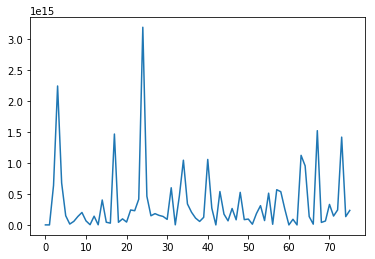

In [12]:
plt.plot(losses)

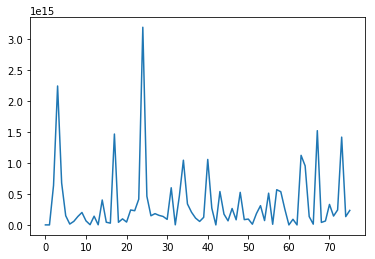

In [13]:
plt.plot(mses)

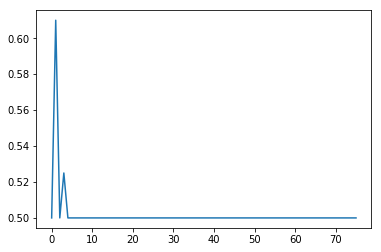

In [14]:
plt.plot(accs)